In [1]:
import matplotlib.pyplot as plt
import os
from load_data import *
import numpy as np
import cv2
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def CNN_1(input_shape, num_classes):
    # Initialize the model as a sequence of layers
    model = Sequential()

    # Add a 2D convolution layer with 32 filters, a 3x3 kernel, using ReLU activation function
    model.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu'))
    # Add a max pooling layer to reduce the spatial dimensions by half
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Add another 2D convolution layer with 64 filters
    model.add(Conv2D(64, (3, 3), activation='relu'))
    # Followed by another max pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Add a third 2D convolution layer with 128 filters
    model.add(Conv2D(128, (3, 3), activation='relu'))
    # And another max pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the output of the last pooling layer to make it ready for the dense layers
    model.add(Flatten())
    # Add a dense layer with 256 neurons
    model.add(Dense(256, activation='relu'))
    # Add the output dense layer with 'num_classes' neurons, one for each class, using softmax activation
    model.add(Dense(num_classes, activation='softmax'))
    
    # Return the constructed model
    return model


def CNN_2(input_shape, num_classes):
    # Initialize the model as a sequence of layers
    model = Sequential()

    # Add a 2D convolution layer with 32 filters, a 3x3 kernel, using ReLU activation function, and specify the input shape
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    # Add a max pooling layer to reduce the spatial dimensions
    model.add(MaxPooling2D((2, 2)))

    # Add a second 2D convolution layer with 64 filters
    model.add(Conv2D(64, (3, 3), activation='relu'))
    # Followed by another max pooling layer
    model.add(MaxPooling2D((2, 2)))

    # Flatten the output to make it ready for the dense layers
    model.add(Flatten())
    # Add a dense layer with 128 neurons
    model.add(Dense(128, activation='relu'))
    # Add the output dense layer with 'num_classes' neurons, one for each class, using softmax activation
    model.add(Dense(num_classes, activation='softmax'))
    
    # Return the constructed model
    return model


In [3]:
def train_CNN_model(X_train, y_train, X_eval, y_eval, num_classes, model_func):

    IMAGE_SIZE = X_train.shape[1]
    # Set the input shape for the model
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
    
    # Instantiate the model using the function provided and the input shape and number of classes
    model = model_func(input_shape=input_shape, num_classes=num_classes) #initialize the architecture

    # Compile the model with Adam optimizer, sparse categorical crossentropy loss, and accuracy as a metric
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # learning rate of 0.0001 for the optimizer
        loss=SparseCategoricalCrossentropy(), 
        metrics=["accuracy"] =
    )

    # set up early stopping to monitor validation accuracy and allow for early termination of training with best weight restoration
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True) 

    history = model.fit(
        X_train, y_train,  # training data and labels
        batch_size=32, 
        epochs=15,  #max of 15 epochs
        validation_data=(X_eval, y_eval),  # Evaluation data for validation
        callbacks=[early_stopping]  # early stopping callback
    )
    
    return model, history, X_eval, y_eval


In [ ]:
img_shape = (225, 225)
results = {
    "models": [],
    "histories": [],
    "X_eval": [],
    "y_eval_cat": []
}

# Load dataset using load_data script; first we'll train on augmented dataset -> we're using split_and_augment_dataset function from load_data
images, labels, label_map = load_dataset(img_shape[0], img_shape[0])
X_train_aug, y_train_aug, X_eval, y_eval, X_test, y_test = split_and_augment_dataset(images, labels, eval_set=True, random_state=42)
num_classes = len(label_map)

#we'll train two models, each one on augmented and original dataset, total of 4 trainings
model_functions = {
    'CNN_1': CNN_1,
    'CNN_2': CNN_2
}

for model_type in ['CNN_1', 'CNN_2']: #train on the augmented training data
    model_func = model_functions[model_type]
    model_aug, history_aug, X_eval_aug, y_eval_cat_aug = train_CNN_model(X_train_aug, y_train_aug, X_eval, y_eval, num_classes, model_func) 
    #save the results for later viz and inspection
    results["models"].append(model_aug)
    results["histories"].append(history_aug)
    results["X_eval"].append(X_eval_aug)
    results["y_eval_cat"].append(y_eval_cat_aug)


X_non_aug, y_non_aug, _ = load_dataset(img_shape[0], img_shape[0])
X_train_non_aug, X_temp, y_train_non_aug, y_temp = train_test_split(X_non_aug, y_non_aug, test_size=0.4, random_state=42) #we have to perform a split since we're not using a split_and_augment_dataset function
X_test_non_aug, X_eval_non_aug, y_test_non_aug, y_eval_non_aug = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
# 60% for training, 20% eval, 20% test (not touched until the last test)


for model_type in ['CNN_1', 'CNN_2']: #train the models on non-augmented dataset
    model_func = model_functions[model_type]
    model_non_aug, history_non_aug, X_eval_non_aug, y_eval_cat_non_aug = train_CNN_model(X_train_non_aug, y_train_non_aug, X_eval_non_aug, y_eval_non_aug, num_classes, model_func) #train on the non-augmented training data
    results["models"].append(model_non_aug)
    results["histories"].append(history_non_aug)
    results["X_eval"].append(X_eval_non_aug)
    results["y_eval_cat"].append(y_eval_cat_non_aug)

lost a cell here with training, the results are still saved though

In [35]:
def evaluate_models(results, model_names):
    for i, model in enumerate(results["models"]):

        # Eval the model on the evaluation data
        loss, accuracy = model.evaluate(results["X_eval"][i], results["y_eval_cat"][i], verbose=0)
        
        # Check if the model was trained with augmentation
        augmentation_status = "With Augmentation" if i < len(model_names) else "Without Augmentation"
        
        print(f"{model_names[i % len(model_names)]} Model ({augmentation_status}): Evaluation Loss: {loss:.4f}, Evaluation Accuracy: {accuracy:.4f}")


model_names = ['CNN_1', 'CNN_2']

evaluate_models(results, model_names)


CNN_1 Model (With Augmentation): Evaluation Loss: 0.4094, Evaluation Accuracy: 0.9175
CNN_2 Model (With Augmentation): Evaluation Loss: 3.4498, Evaluation Accuracy: 0.8746
CNN_1 Model (Without Augmentation): Evaluation Loss: 0.7212, Evaluation Accuracy: 0.8929
CNN_2 Model (Without Augmentation): Evaluation Loss: 3.9098, Evaluation Accuracy: 0.8778


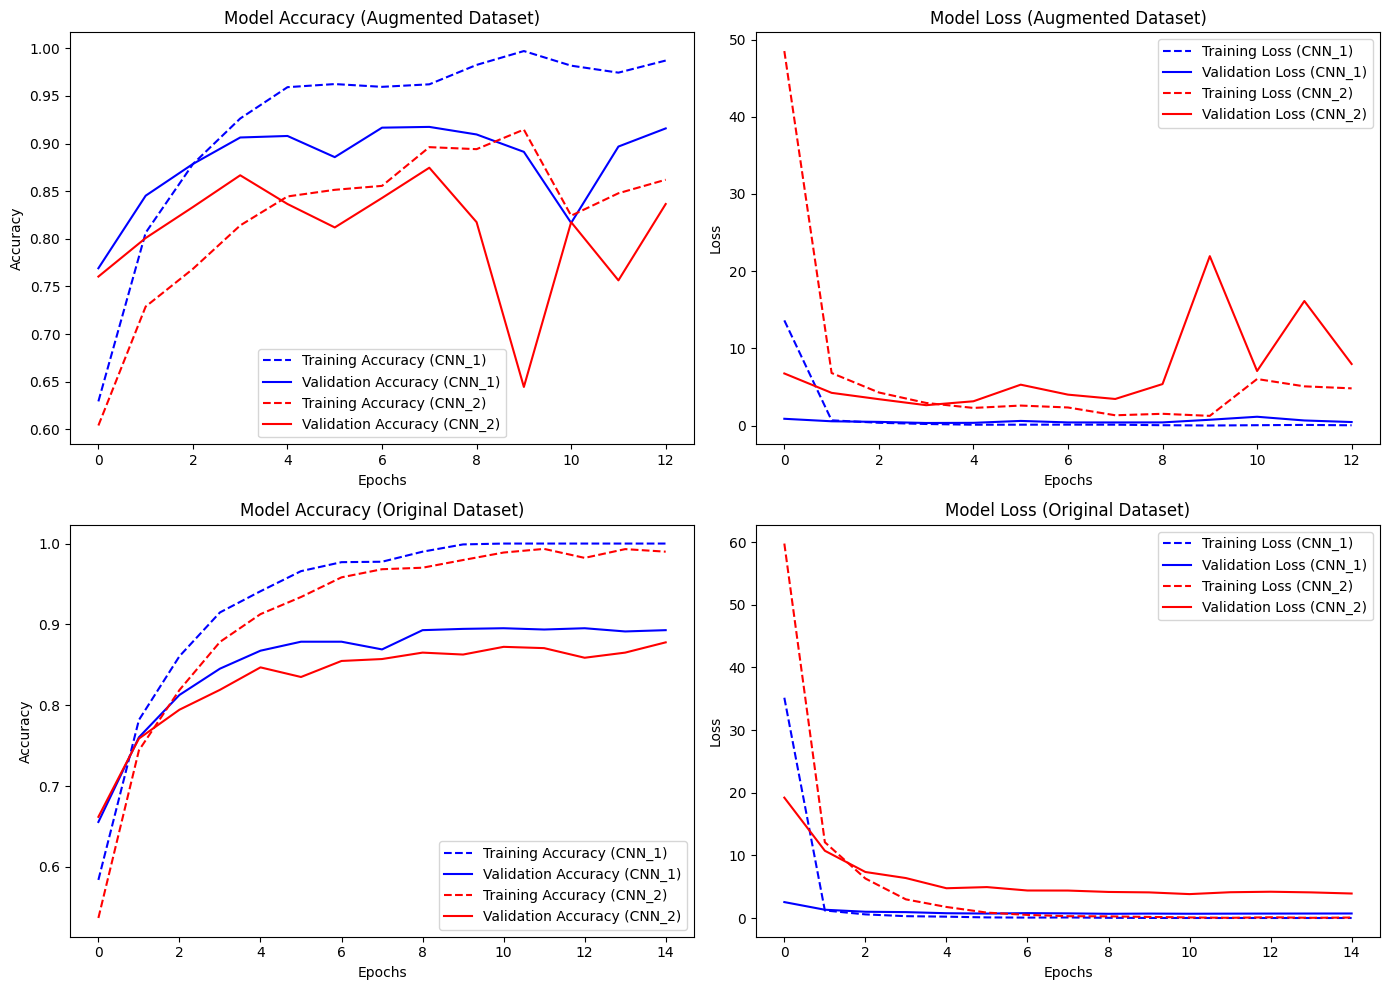

In [31]:
def plot_training_results(results, model_names):
    plt.figure(figsize=(14, 10))
    
    # colors for each model
    colors = {'CNN_1': 'blue', 'CNN_2': 'red'}
    
    # Accuracy for Augmented Dataset
    plt.subplot(2, 2, 1)
    for i, model_name in enumerate(model_names):
        index = i  # augmented models are first in the list
        epochs = range(len(results["histories"][index].history['accuracy']))
        
        plt.plot(epochs, results["histories"][index].history['accuracy'], '--', label=f'Training Accuracy ({model_name})', color=colors[model_name])
        plt.plot(epochs, results["histories"][index].history['val_accuracy'], '-', label=f'Validation Accuracy ({model_name})', color=colors[model_name])
    
    plt.title('Model Accuracy (Augmented Dataset)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss for Augmented Dataset
    plt.subplot(2, 2, 2)
    for i, model_name in enumerate(model_names):
        index = i  # Augmented models are first in the list
        epochs = range(len(results["histories"][index].history['loss']))
        
        plt.plot(epochs, results["histories"][index].history['loss'], '--', label=f'Training Loss ({model_name})', color=colors[model_name])
        plt.plot(epochs, results["histories"][index].history['val_loss'], '-', label=f'Validation Loss ({model_name})', color=colors[model_name])
    
    plt.title('Model Loss (Augmented Dataset)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy for Original Dataset
    plt.subplot(2, 2, 3)
    for i, model_name in enumerate(model_names):
        index = i + len(model_names)  # Non-augmented models are next in the list
        epochs = range(len(results["histories"][index].history['accuracy']))
        
        plt.plot(epochs, results["histories"][index].history['accuracy'], '--', label=f'Training Accuracy ({model_name})', color=colors[model_name])
        plt.plot(epochs, results["histories"][index].history['val_accuracy'], '-', label=f'Validation Accuracy ({model_name})', color=colors[model_name])
    
    plt.title('Model Accuracy (Original Dataset)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss for Original Dataset
    plt.subplot(2, 2, 4)
    for i, model_name in enumerate(model_names):
        index = i + len(model_names)  # Non-augmented models are next in the list
        epochs = range(len(results["histories"][index].history['loss']))
        
        plt.plot(epochs, results["histories"][index].history['loss'], '--', label=f'Training Loss ({model_name})', color=colors[model_name])
        plt.plot(epochs, results["histories"][index].history['val_loss'], '-', label=f'Validation Loss ({model_name})', color=colors[model_name])
    
    plt.title('Model Loss (Original Dataset)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('cnn_aug_vs_non_aug.png', dpi=300, bbox_inches='tight')
    plt.show()
  

plot_training_results(results, ['CNN_1', 'CNN_2'])

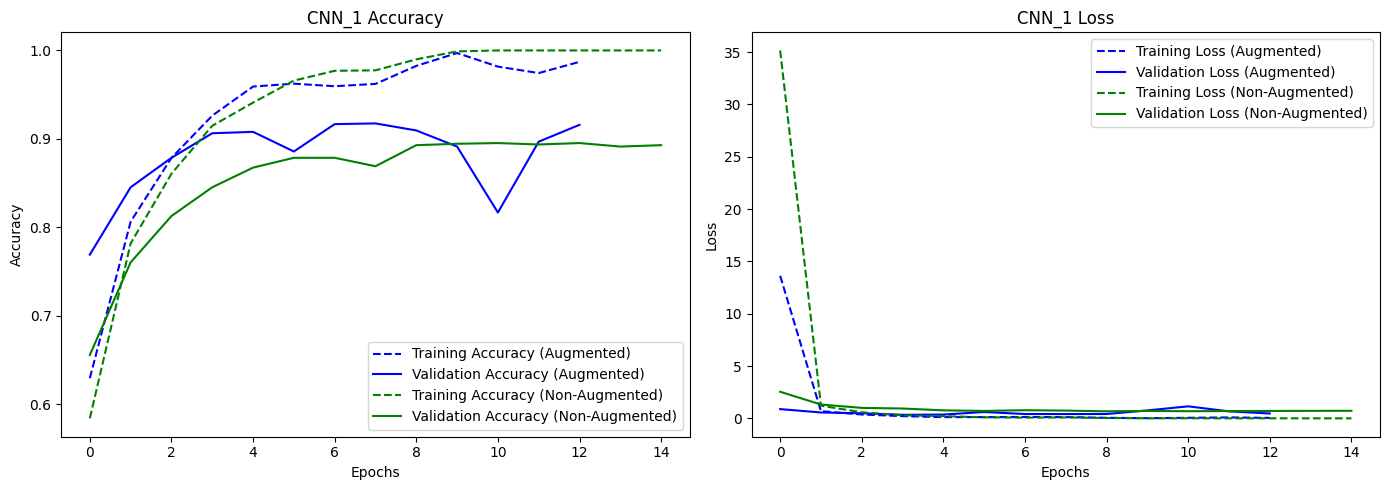

In [33]:
#plotting individual results for CNN1 for further visual inspection
def plot_cnn_1_results(results):

    plt.figure(figsize=(14, 5))
    
    colors = {'Augmented': 'blue', 'Non-Augmented': 'green'}
    

    augmented_index = 0 
    non_augmented_index = 2 
    
    # Accuracy
    plt.subplot(1, 2, 1)
    for index, dataset_type in zip([augmented_index, non_augmented_index], ['Augmented', 'Non-Augmented']):
        epochs = range(len(results["histories"][index].history['accuracy']))
        plt.plot(epochs, results["histories"][index].history['accuracy'], '--', label=f'Training Accuracy ({dataset_type})', color=colors[dataset_type])
        plt.plot(epochs, results["histories"][index].history['val_accuracy'], '-', label=f'Validation Accuracy ({dataset_type})', color=colors[dataset_type])
        
    plt.title('CNN_1 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    for index, dataset_type in zip([augmented_index, non_augmented_index], ['Augmented', 'Non-Augmented']):
        epochs = range(len(results["histories"][index].history['loss']))
        plt.plot(epochs, results["histories"][index].history['loss'], '--', label=f'Training Loss ({dataset_type})', color=colors[dataset_type])
        plt.plot(epochs, results["histories"][index].history['val_loss'], '-', label=f'Validation Loss ({dataset_type})', color=colors[dataset_type])
        
    plt.title('CNN_1 Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig('cnn_1.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_cnn_1_results(results)


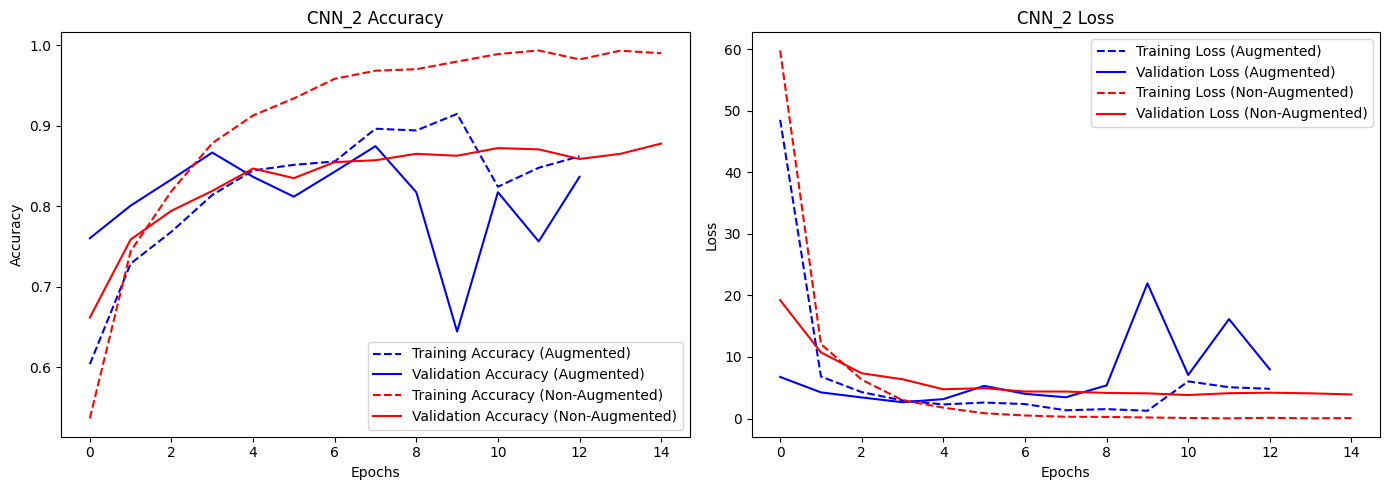

In [34]:
#same for CNN2...
def plot_cnn_2_results(results):
    plt.figure(figsize=(14, 5))
    
    colors = {'Augmented': 'blue', 'Non-Augmented': 'red'}
    
    augmented_index = 1  # CNN_2 augmented data is second in the list
    non_augmented_index = 3  # CNN_2 non-augmented data is fourth in the list
    
    # Accuracy
    plt.subplot(1, 2, 1)
    for index, dataset_type in zip([augmented_index, non_augmented_index], ['Augmented', 'Non-Augmented']):
        epochs = range(len(results["histories"][index].history['accuracy']))
        plt.plot(epochs, results["histories"][index].history['accuracy'], '--', label=f'Training Accuracy ({dataset_type})', color=colors[dataset_type])
        plt.plot(epochs, results["histories"][index].history['val_accuracy'], '-', label=f'Validation Accuracy ({dataset_type})', color=colors[dataset_type])
        
    plt.title('CNN_2 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    for index, dataset_type in zip([augmented_index, non_augmented_index], ['Augmented', 'Non-Augmented']):
        epochs = range(len(results["histories"][index].history['loss']))
        plt.plot(epochs, results["histories"][index].history['loss'], '--', label=f'Training Loss ({dataset_type})', color=colors[dataset_type])
        plt.plot(epochs, results["histories"][index].history['val_loss'], '-', label=f'Validation Loss ({dataset_type})', color=colors[dataset_type])
        
    plt.title('CNN_2 Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('cnn_2.png', dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()


plot_cnn_2_results(results)


CNN1 is the preferred model here, CNN2 shows some random fluctuations upon introducing the augmented dataset.<br>CNN1 has benefitted largely from introducing an augmented dataset (improvement from 89 to 92). Therefore we're now merging eval (first augmenting it) into training set and training the model on a larger training sample. The final model will be tested on a test set that has been held out and not used until the last evaluation.

In [18]:
print("AUGMENTED DATASET RUN SHAPES: ")
print("X_train_aug shape:", X_train_aug.shape)
print("y_train_aug shape:", y_train_aug.shape)
print("X_eval shape:", X_eval.shape)
print("y_eval shape:", y_eval.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

AUGMENTED DATASET RUN SHAPES: 
X_train_aug shape: (11340, 225, 225, 3)
y_train_aug shape: (11340,)
X_eval shape: (1260, 225, 225, 3)
y_eval shape: (1260,)
X_test shape: (1260, 225, 225, 3)
y_test shape: (1260,)


In [19]:
X_eval_augmented, y_eval_augmented = augment_data(X_eval, y_eval) #augmenting the eval split

#merging the augmented eval onto training set
X_train_final = np.concatenate((X_train_aug, X_eval_augmented), axis=0) 
y_train_final = np.concatenate((y_train_aug, y_eval_augmented), axis=0) 

In [20]:
print("AUGMENTED DATASET RUN SHAPES: ")
print("X_train_final shape:", X_train_final.shape)
print("y_train_final shape:", y_train_final.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


AUGMENTED DATASET RUN SHAPES: 
X_train_final shape: (15120, 225, 225, 3)
y_train_final shape: (15120,)
X_test shape: (1260, 225, 225, 3)
y_test shape: (1260,)


In [24]:
num_classes = 4
model_full, history_full, _, _ = train_CNN_model(X_train_final, y_train_final, X_test, y_test, num_classes, CNN_1) #final training with 15120 training images

Epoch 1/15
473/473 [==============================] - 65s 137ms/step - loss: 16.3198 - accuracy: 0.6598 - val_loss: 2.2009 - val_accuracy: 0.7349
Epoch 2/15
473/473 [==============================] - 62s 131ms/step - loss: 1.0356 - accuracy: 0.7869 - val_loss: 0.8453 - val_accuracy: 0.8095
Epoch 3/15
473/473 [==============================] - 62s 131ms/step - loss: 0.6348 - accuracy: 0.8431 - val_loss: 0.6425 - val_accuracy: 0.8786
Epoch 4/15
473/473 [==============================] - 61s 129ms/step - loss: 0.4322 - accuracy: 0.8863 - val_loss: 1.2817 - val_accuracy: 0.8302
Epoch 5/15
473/473 [==============================] - 61s 130ms/step - loss: 0.3653 - accuracy: 0.9073 - val_loss: 1.1610 - val_accuracy: 0.8706
Epoch 6/15
473/473 [==============================] - 61s 130ms/step - loss: 0.3183 - accuracy: 0.9222 - val_loss: 0.6854 - val_accuracy: 0.8976
Epoch 7/15
473/473 [==============================] - 61s 130ms/step - loss: 0.2639 - accuracy: 0.9377 - val_loss: 0.6662 - val_a

In [25]:
loss, accuracy = model_full.evaluate(X_test, y_test)
print("FINAL RUN - CNN (1) MODEL (AUGMENTED DATASET)")
print("Evaluation Loss:", loss)
print("Evaluation Accuracy:", accuracy)

40/40 [==============================] - 3s 63ms/step - loss: 0.6740 - accuracy: 0.9317
FINAL RUN - CNN (1) MODEL (AUGMENTED DATASET)
Evaluation Loss: 0.6739581227302551
Evaluation Accuracy: 0.9317460656166077


In [26]:
import os
import json

save_dir = "final_results/CNN1"

# Create the dir if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# # Save the model
# model_save_path = os.path.join(save_dir, "model_cnn1.h5")
# model_full.save(model_save_path)
# print(f"Model saved to {model_save_path}")

# Save the history
history_save_path = os.path.join(save_dir, "history_cnn1.json")
with open(history_save_path, 'w') as f:
    json.dump(history_full.history, f)
print(f"Training history saved to {history_save_path}")

Training history saved to final_results/CNN1/history_cnn1.json


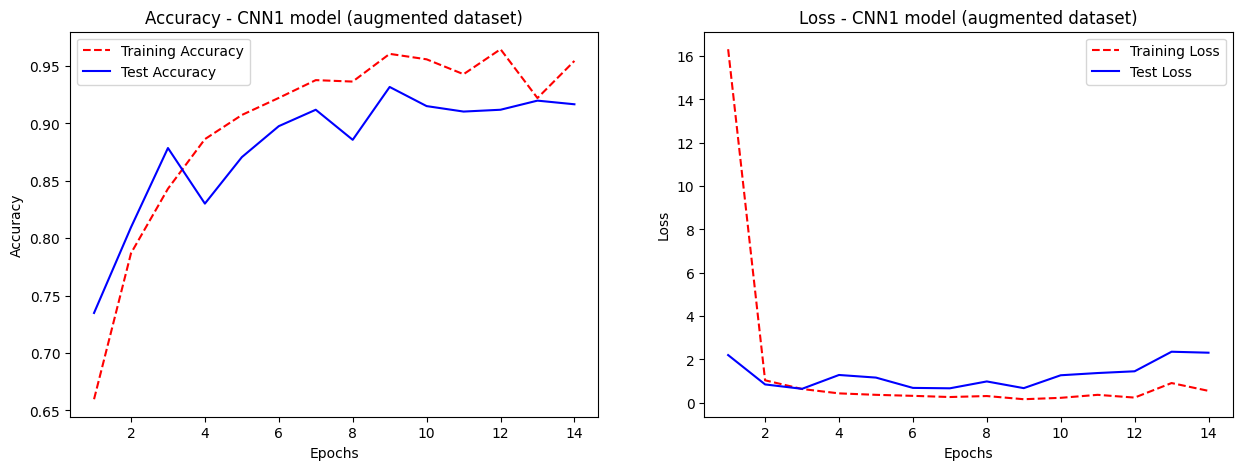

In [27]:
import matplotlib.pyplot as plt

epochs = range(1, len(history_full.history['accuracy']) + 1)
train_loss = history_full.history['loss']
train_accuracy = history_full.history['accuracy']
test_loss = history_full.history.get('val_loss', None)
test_accuracy = history_full.history.get('val_accuracy', None)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training and test accuracy
ax1.plot(epochs, train_accuracy, 'r--', label='Training Accuracy')
if test_accuracy is not None:
    ax1.plot(epochs, test_accuracy, 'b-', label='Test Accuracy')
ax1.set_title('Accuracy - CNN1 model (augmented dataset)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Training and test loss
ax2.plot(epochs, train_loss, 'r--', label='Training Loss')
if test_loss is not None:
    ax2.plot(epochs, test_loss, 'b-', label='Test Loss')
ax2.set_title('Loss - CNN1 model (augmented dataset)')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.savefig('img/CNN1_final_learning_curve.png', dpi=300)
plt.show()


40/40 [==============================] - 3s 64ms/step


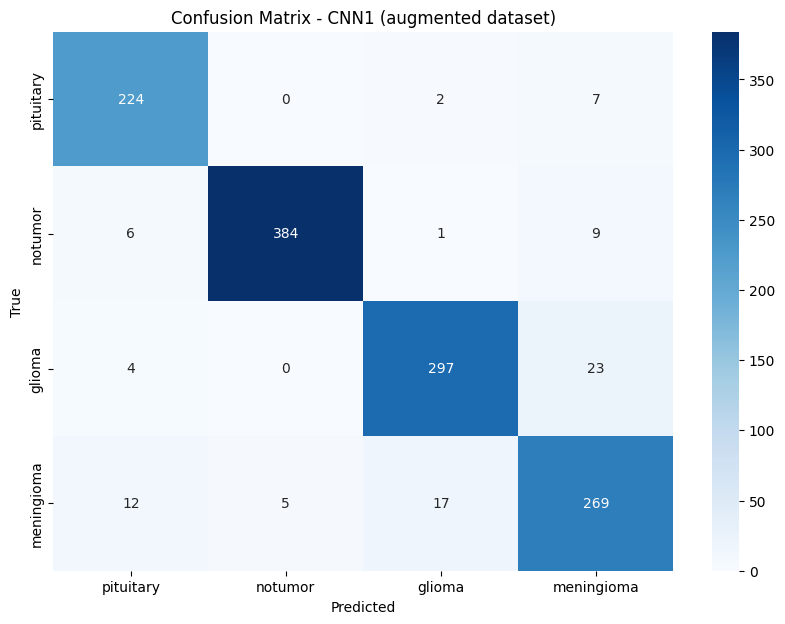

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Make predictions on the test set
y_pred = model_full.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Reverse the label map to get a mapping from index to class name
index_to_class_name = {v: k for k, v in label_map.items()}

# Convert class indices to class names
y_test_names = np.vectorize(index_to_class_name.get)(y_test)
y_pred_classes_names = np.vectorize(index_to_class_name.get)(y_pred_classes)

# Compute the confusion matrix
cm = confusion_matrix(y_test_names, y_pred_classes_names, labels=list(label_map.keys()))

# visualize it
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title('Confusion Matrix - CNN1 (augmented dataset)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('img/cnn1_final_confusion_matrix.png', dpi=300)
plt.show()

In [29]:
print('Classification Report (CNN MODEL):\n', classification_report(y_test, y_pred_classes))

Classification Report (RESNET MODEL):
               precision    recall  f1-score   support

           0       0.91      0.96      0.94       233
           1       0.99      0.96      0.97       400
           2       0.94      0.92      0.93       324
           3       0.87      0.89      0.88       303

    accuracy                           0.93      1260
   macro avg       0.93      0.93      0.93      1260
weighted avg       0.93      0.93      0.93      1260



In [30]:
print("Once again...\nFINAL RUN - CNN MODEL (AUGMENTED DATASET)")
print("Evaluation Loss:", loss)
print("Evaluation Accuracy:", accuracy)

Once again...
FINAL RUN - CNN MODEL (AUGMENTED DATASET)
Evaluation Loss: 0.6739581227302551
Evaluation Accuracy: 0.9317460656166077
